In [0]:
import numpy as np
import pandas as pd

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torchvision.models as models
#from torchvision import transforms
#from torch.utils.data import Dataset, DataLoader
#import torch.optim as optim

from sklearn import metrics

from skimage import io, color

import time
import os
import pickle

import matplotlib.pyplot as plt
#import scikitplot as skplt

In [0]:
train_X = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
val_X = pd.read_csv('val_X.csv')
val_y = pd.read_csv('val_y.csv')
train = pd.read_csv('train.csv')
val = pd.read_csv('dev.csv')

In [0]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [0]:
sent = [row.split() for row in train_X['cleaned review']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
sentences = phrases[sent]

In [0]:
import multiprocessing
from gensim.models import Word2Vec

In [0]:
cores = multiprocessing.cpu_count()

In [0]:
print(cores)

8


In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,sg = 1)

In [0]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [0]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(206254166, 431357850)

In [0]:
from gensim.models import KeyedVectors

In [0]:
#from gensim.test.utils import get_tmpfile
#path = get_tmpfile("wordvectors.kv")
#w2v_model.wv.save(path)

In [0]:
w2v_model.save("word2vec.model")

In [0]:
w2v_model.wv.save("model.wv")

In [0]:
wv = KeyedVectors.load("model.wv", mmap='r')

In [0]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
ros = RandomOverSampler()
train_X_ros, train_y_ros = ros.fit_sample(train_X, np.array(train_y['label']))
train_X_up = pd.DataFrame(train_X_ros, columns = ['ex_id','user_id','prod_id','rating','date','review','cleaned review'])
train_y_up = pd.DataFrame(train_y_ros)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
vectorizer.fit(train_X_up['cleaned review'])
features = vectorizer.get_feature_names()
BoW_train_X = vectorizer.transform(train_X_up['cleaned review'])
BoW_val_X = vectorizer.transform(val_X['cleaned review'])

In [0]:
sent = [row.split() for row in train_X_up['cleaned review']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
sentences = phrases[sent]

In [0]:
w2v_feature = []
for s in sentences:
    avg_embedding = np.zeros(300)
    n = 0
    for w in s:
        if w in wv:
            n=n+1
            avg_embedding = avg_embedding+np.array(wv[w])
    if n!=0:
        avg_embedding = avg_embedding/n
    w2v_feature.append(avg_embedding)

In [0]:
w2v_feature = np.array(w2v_feature)

In [0]:
w2v_feature.shape

(450110, 300)

In [0]:
sentval = [row.split() for row in val_X['cleaned review']]
phrases = Phrases(sentval, min_count=30, progress_per=10000)
sentencesval = phrases[sentval]

In [0]:
w2v_feature_val = []
for s in sentencesval:
    avg_embedding = np.zeros(300)
    n=0
    for w in s:
        if w in wv:
            n=n+1
            avg_embedding = avg_embedding+np.array(wv[w])
    if n!=0:
        avg_embedding = avg_embedding/n
    w2v_feature_val.append(avg_embedding)

In [0]:
w2v_feature_val = np.array(w2v_feature_val)
w2v_feature_val.shape

(35918, 300)

In [0]:
from scipy.sparse import csr_matrix
w2v_feature_s = csr_matrix(w2v_feature)
sparse.save_npz("w2v_feature_train.npz", w2v_feature_s)
w2v_feature_val_s = csr_matrix(w2v_feature_val)
sparse.save_npz("w2v_feature_val.npz", w2v_feature_val_s)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
def trainlr(BoW_train_X,train_y,BoW_val_X,val_y):
    lr = LogisticRegression(max_iter=20,C=0.15)

    lr.fit(BoW_train_X, train_y)
    preds_nb = lr.predict_proba(BoW_val_X)[:,1]
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')

    nb_fpr, nb_tpr, nb_thresholds = roc_curve(val_y, preds_nb)
    nb_roc_auc = auc(nb_fpr, nb_tpr)
    ap = average_precision_score(val_y, preds_nb)
    nb_curve = plt.plot(nb_fpr, nb_tpr, label = 'LR' + ' (AUC = %0.3f)' % 
                        roc_auc_score(val_y, preds_nb)+', (AP = %0.3f)' % ap)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    return ap,nb_roc_auc

C:\Users\xinme\Anaconda2\envs\py3.6\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


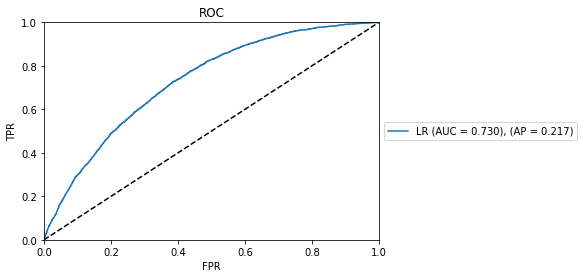

(0.2174017916633686, 0.7295204481852681)

In [0]:
trainlr(BoW_train_X,train_y_up,BoW_val_X,val_y)

C:\Users\xinme\Anaconda2\envs\py3.6\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


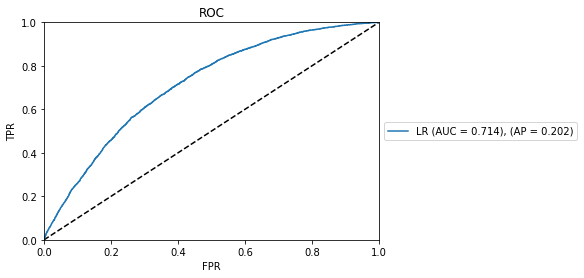

(0.20188168298476056, 0.713936188593773)

In [0]:
trainlr(w2v_feature,train_y,w2v_feature_val,val_y)